In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from word2vec_selection.classes import Word2VecModel

In [88]:
from word2vec_selection.functions import *
model_w2v_settings = return_best_model()

In [89]:
model_w2v = Word2VecModel(model_w2v_settings)

In [ ]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

In [ ]:
df['sample'].value_counts()


In [92]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]

X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])



y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
import json

# if file does not exist write empty dict
if not os.path.exists('grid_search_results.json'):
    with open('grid_search_results.json', 'w') as f:
        json.dump({}, f)

with open('grid_search_results.json', 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

In [ ]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
models = list()
for model in grids:
    models.append(model)
models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

for model in grids:
    # check if model has already been trained - if 'best_params' exists in grid - if so, skip
    if not model in models_to_CV:
        continue

    print(f'Grid search for model: {model}')
    grid = grids[model]

    if model == 'decision_tree_grid':
        clf = DecisionTreeClassifier()
    elif model == 'random_forest_grid':
        clf = RandomForestClassifier()
    elif model == 'xgboost_grid':
        clf = XGBClassifier()
    elif model == 'lightgbm_grid':
        clf = LGBMClassifier()
    elif model == 'catboost_grid':
        clf = CatBoostClassifier(verbose=0)

    # do grid search
    grid_search = GridSearchCV(clf, grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)

    # save best model
    roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test_scaled)[:, 1])
    f1 = f1_score(y_test, grid_search.predict(X_test_scaled))

    grids[model]['best_params'] = grid_search.best_params_
    grids[model]['roc_auc'] = roc_auc
    grids[model]['f1'] = f1

    # save grid search results
    with open('grid_search_results.json', 'w') as f:
        json.dump(model_settings, f)


In [103]:
# order grids by roc_auc descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['roc_auc'], reverse=True)}

# get model ranking
model_ranking_auc = list()
for model_name, grid in grids.items():
    model_ranking_auc.append((model_name, grid['roc_auc']))

model_ranking_auc 

[('catboost_grid', 0.9023705609240388),
 ('lightgbm_grid', 0.8995012624180527),
 ('xgboost_grid', 0.8978925497180171),
 ('random_forest_grid', 0.8969251234018227),
 ('decision_tree_grid', 0.8189227121650197)]

In [104]:
# order grids by f1 descending
grids = {k: v for k, v in sorted(grids.items(), key=lambda item: item[1]['f1'], reverse=True)}

# get model ranking
model_ranking_f1 = list()
for model_name, grid in grids.items():
    model_ranking_f1.append((model_name, grid['f1']))

model_ranking_f1 

[('lightgbm_grid', 0.7736263736263737),
 ('xgboost_grid', 0.7666422823701535),
 ('catboost_grid', 0.7636632200886263),
 ('random_forest_grid', 0.7557879014189695),
 ('decision_tree_grid', 0.6853677028051555)]

# WINNER - lightgbm

In [106]:
# get params for best model
best_model = model_ranking_auc[1][0]
best_params = grids[best_model]['best_params']
best_model, best_params

('lightgbm_grid',
 {'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 500,
  'num_leaves': 155})

In [108]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(max_depth= -1, n_estimators=500, num_leaves= 155, learning_rate= 0.1)
clf.fit(X_train_scaled, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])
f1 = f1_score(y_test, clf.predict(X_test_scaled))

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

ROC AUC: 0.8995012624180527
F1: 0.7736263736263737


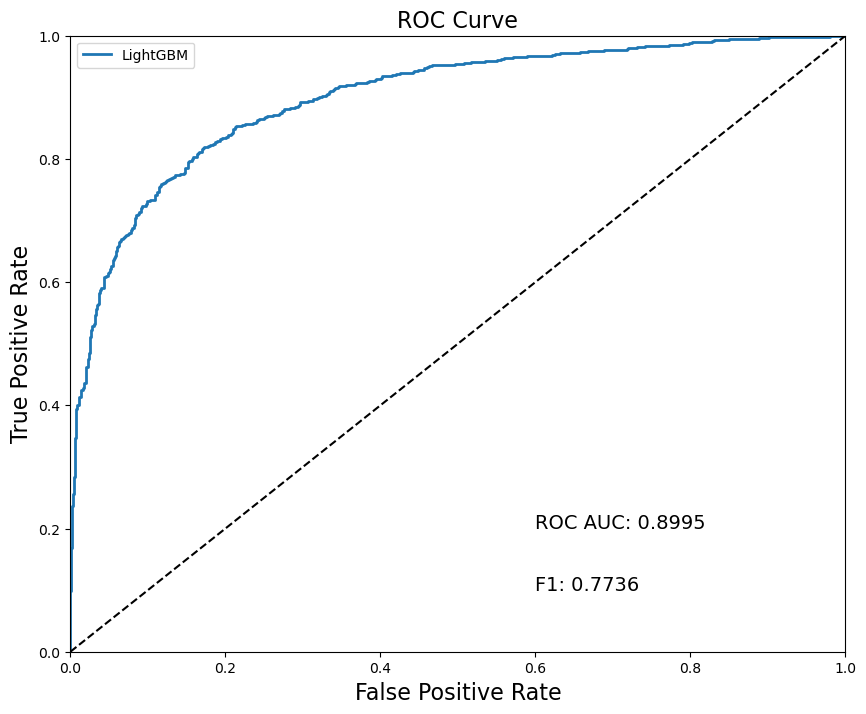

In [109]:
from sklearn.metrics import roc_curve

# plot ROC curve    
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label='LightGBM')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve', fontsize=16)
# add info about roc_auc and f1
plt.text(0.6, 0.2, f'ROC AUC: {roc_auc:.4f}', fontsize=14)
plt.text(0.6, 0.1, f'F1: {f1:.4f}', fontsize=14)

plt.legend()
plt.show()

In [110]:
# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, clf.predict(X_test_scaled))


array([[1015,  108],
       [ 201,  528]])

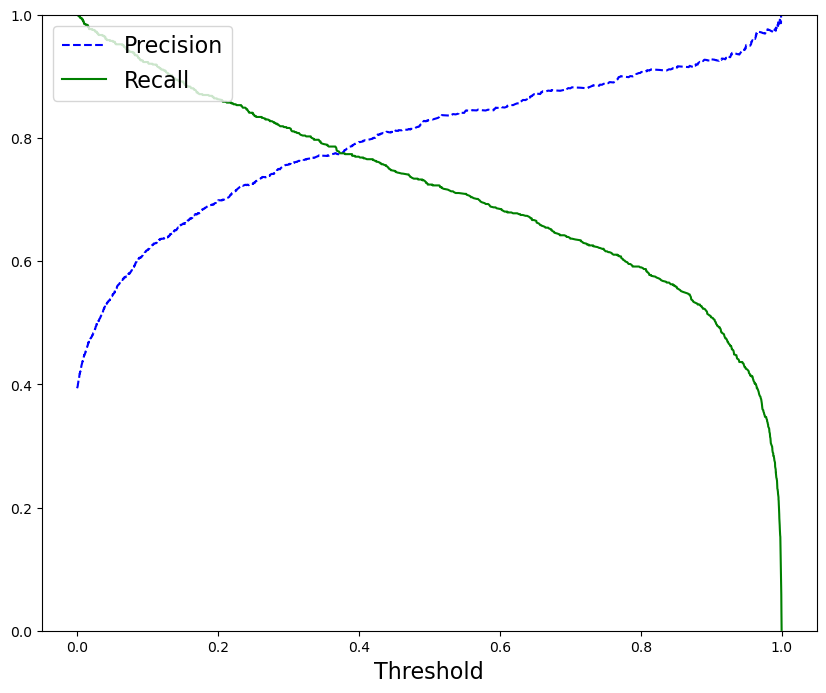

In [111]:
# find best threshold
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test_scaled)[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.ylim([0, 1])
plt.show()


In [112]:
# get the point at which precision and recall are equal
threshold = thresholds[np.argmax(precisions == recalls)]
threshold

0.3749938102239996

In [113]:
# get predictions for test data with best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)

# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)


array([[959, 164],
       [164, 565]])

In [114]:
# print f1 score
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.7750342935528121

In [115]:
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold
    

  0%|          | 0/10000 [00:00<?, ?it/s]

0.30123012301230123

In [116]:
# find auc and f1 for best threshold
y_pred = (clf.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = clf.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

ROC AUC: 0.8995012624180527
F1: 0.785997357992074


In [117]:
# save clf to pickle file
import pickle

with open('predictive_models/lightgbm.pkl', 'wb') as f:
    pickle.dump(clf, f)

# save scaler to pickle file
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)